In [1]:
import pandas as pd
from eventclass import *
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Investigating Fencer Mobility to Div 1 from ROC events 2021-2022 season
With the elimination of Div II and Div III NAC events from the USA Fencing schedule, many adults age 20-40 without a current C rating are wondering how they can compete at NAC events again in the future.

Members of the leadership at USA Fencing have indicated that the Regional Open Circuit (ROC) events meet the competitive needs of fencers in this category. We are using results data from ROC events over the 2021-2022 season to determine if fencers in this age bracket who are currently ineligible for Division 1 have a path to Division 1 competition through ROC events.

This data is courtesy of Dan Berke at FencingTime. We are currently discussing the most appropriate way to share this with the community. For now, we provide information about the data for the purposes of transparency in the analysis steps.

## Data ingest
Here is a list of the columns provided by FencingTime

In [2]:
rocs_raw = pd.read_csv('ROCResults.csv')
rocs_raw.columns

Index(['tournament', 'eventStartTime', 'city', 'state', 'level', 'gender',
       'weapon', 'eventClass', 'place', 'name', 'club', 'division',
       'memberNum', 'classification', 'earned', 'qualifiedFor'],
      dtype='object')

## Matching States and Regions
This data has tournaments listed by what state they are in. Let's make sure we know what region each state is a part of. Region assignments taken from this website: https://www.usafencing.org/regional-info
N.B. Alaska and Hawaii are not assigned regions, but D.C. is a part of Region 6, so our record should have 49 entries.

In [3]:
region_1_states = ['WA','OR','ID','MT','WY']
region_2_states = ['ND','SD','NE','KS','MN','IA','MO','WI','IL','MI','IN','OH','KY']
region_3_states = ['ME','NH','VT','MA','NY','RI','CT','NJ','PA']
region_4_states = ['CA','NV','AZ','NM','UT','CO']
region_5_states = ['TX','LA','OK','AR']
region_6_states = ['WV','DE','MD','VA','DC','TN','NC','SC','GA','AL','MS','FL']
region2state = {1:region_1_states,2:region_2_states,3:region_3_states,4:region_4_states,5:region_5_states,6:region_6_states}
state2region = {}
for region,region_states in region2state.items():
    for state in region_states:
        state2region[state] = region
print(f'We have accounted for {len(state2region.keys())} states')
rocs_raw['event_region'] = rocs_raw['state'].map(state2region)

We have accounted for 49 states


## Consolidating ratings
Now let's ignore whether a rating was earned in the first or second half of the season (i.e. we will consider A21 and A22 just as earning an A at some point during the season). Note that this column will have "nan" (i.e. "not a number") values for fencers that did not earn a rating at the event; these values are ignored.

Similarly, when determining whether a fencer already had a Division 1 eligible rating, we will ignore what year they earned their original classification before the tournament.

In [4]:
season_ratings = {x:x[0] for x in rocs_raw.classification.unique()}
rocs_raw['classification_season'] = rocs_raw['classification'].map(season_ratings)
season_earned_ratings = {x:x[0] for x in rocs_raw.earned.dropna().unique()}
rocs_raw['earned_season'] = rocs_raw['earned'].map(season_earned_ratings)
print('Ratings before events: ',sorted(rocs_raw.classification_season.unique()))
print('Ratings after events: ',rocs_raw.earned_season.unique())

Ratings before events:  ['A', 'B', 'C', 'D', 'E', 'U']
Ratings after events:  ['C' 'D' nan 'E' 'A' 'B']


## Consolidating Events
Add an additional column for Gender+Weapon combos

In [5]:
rocs_raw['gw_event'] = rocs_raw['gender']+rocs_raw['weapon']

# Tournament Opportunities
First, let's see what classification level of events were possible last season. That is, what overall event rating was possible at each event, regardless of what the final classification was (i.e. we account for the ratings of those who attended the tournament and disregard any upsets that changed the actual final event classifications.) This uses functions from eventclass.py based on https://askfred.net/Info/eventClass.php

In [6]:
tournament_names = rocs_raw.tournament.unique()
tournaments = []
regions = []
levels = []
events = []
possible_classifications = []
for tournament in tournament_names:
    tournament_df = rocs_raw[rocs_raw.tournament==tournament]
    region = tournament_df.event_region.to_list()[0]
    tournament_levels = tournament_df.level.unique()
    for level in tournament_levels:
        level_df = tournament_df[tournament_df.level==level]
        level_events = level_df.gw_event.unique()
        for event in level_events:
            event_df = level_df[level_df.gw_event==event]
            possible_classification = get_event_rating(event_df.classification_season.to_list())
            tournaments.append(tournament)
            regions.append(region)
            levels.append(level)
            events.append(event)
            possible_classifications.append(possible_classification)
classification_df = pd.DataFrame.from_dict({'tournament':tournaments,'region':regions,'level':levels,'event':events,'possible_classification':possible_classifications})

### All possible event classifications at ROC tournaments

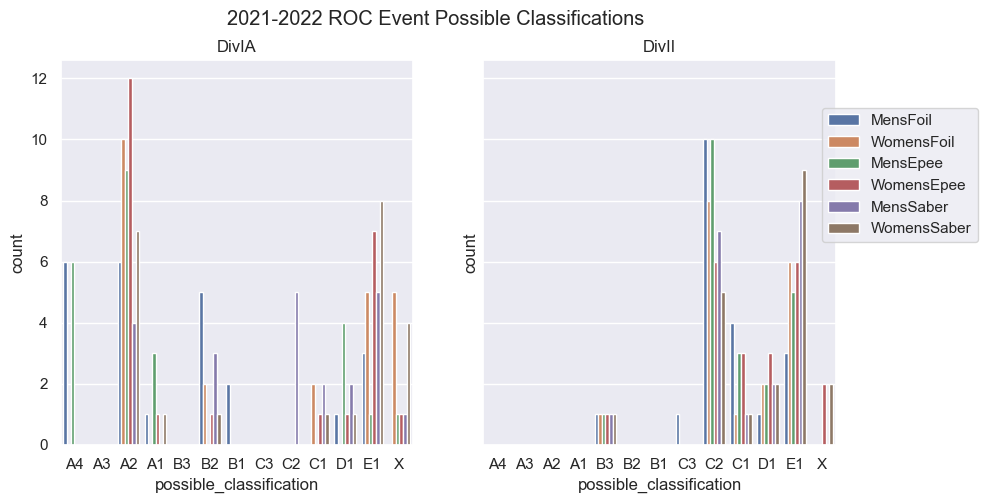

In [7]:
#ORDER = natsorted(classification_df.possible_classification.unique())
ORDER = ['A4','A3','A2','A1','B3','B2','B1','C3','C2','C1','D1','E1','X']
fig, axes = plt.subplots(1,2,figsize=(10,5),sharey=True)
fig.suptitle('2021-2022 ROC Event Possible Classifications')
for i,l in enumerate(['DivIA','DivII']):
    df_l = classification_df[classification_df.level==l]
    a = sns.countplot(ax=axes[i],data=df_l,x='possible_classification',hue='event',order=ORDER)
    a.get_legend().remove()
    a.set_title(l)

handles,labels = a.get_legend_handles_labels()
fig.legend(handles,labels,loc='lower right',bbox_to_anchor=(1.05,0.5))

In [8]:
classification_df.head()

,tournament,region,level,event,possible_classification
0,TFC FallFest DIV2/VET ROC,4,DivII,MensFoil,C2
1,TFC FallFest DIV2/VET ROC,4,DivII,WomensFoil,C2
2,TFC FallFest DIV2/VET ROC,4,DivII,MensEpee,C2
3,TFC FallFest DIV2/VET ROC,4,DivII,WomensEpee,D1
4,TFC FallFest DIV2/VET ROC,4,DivII,MensSaber,D1


### Regional tournament classification availability per weapon/gender combination

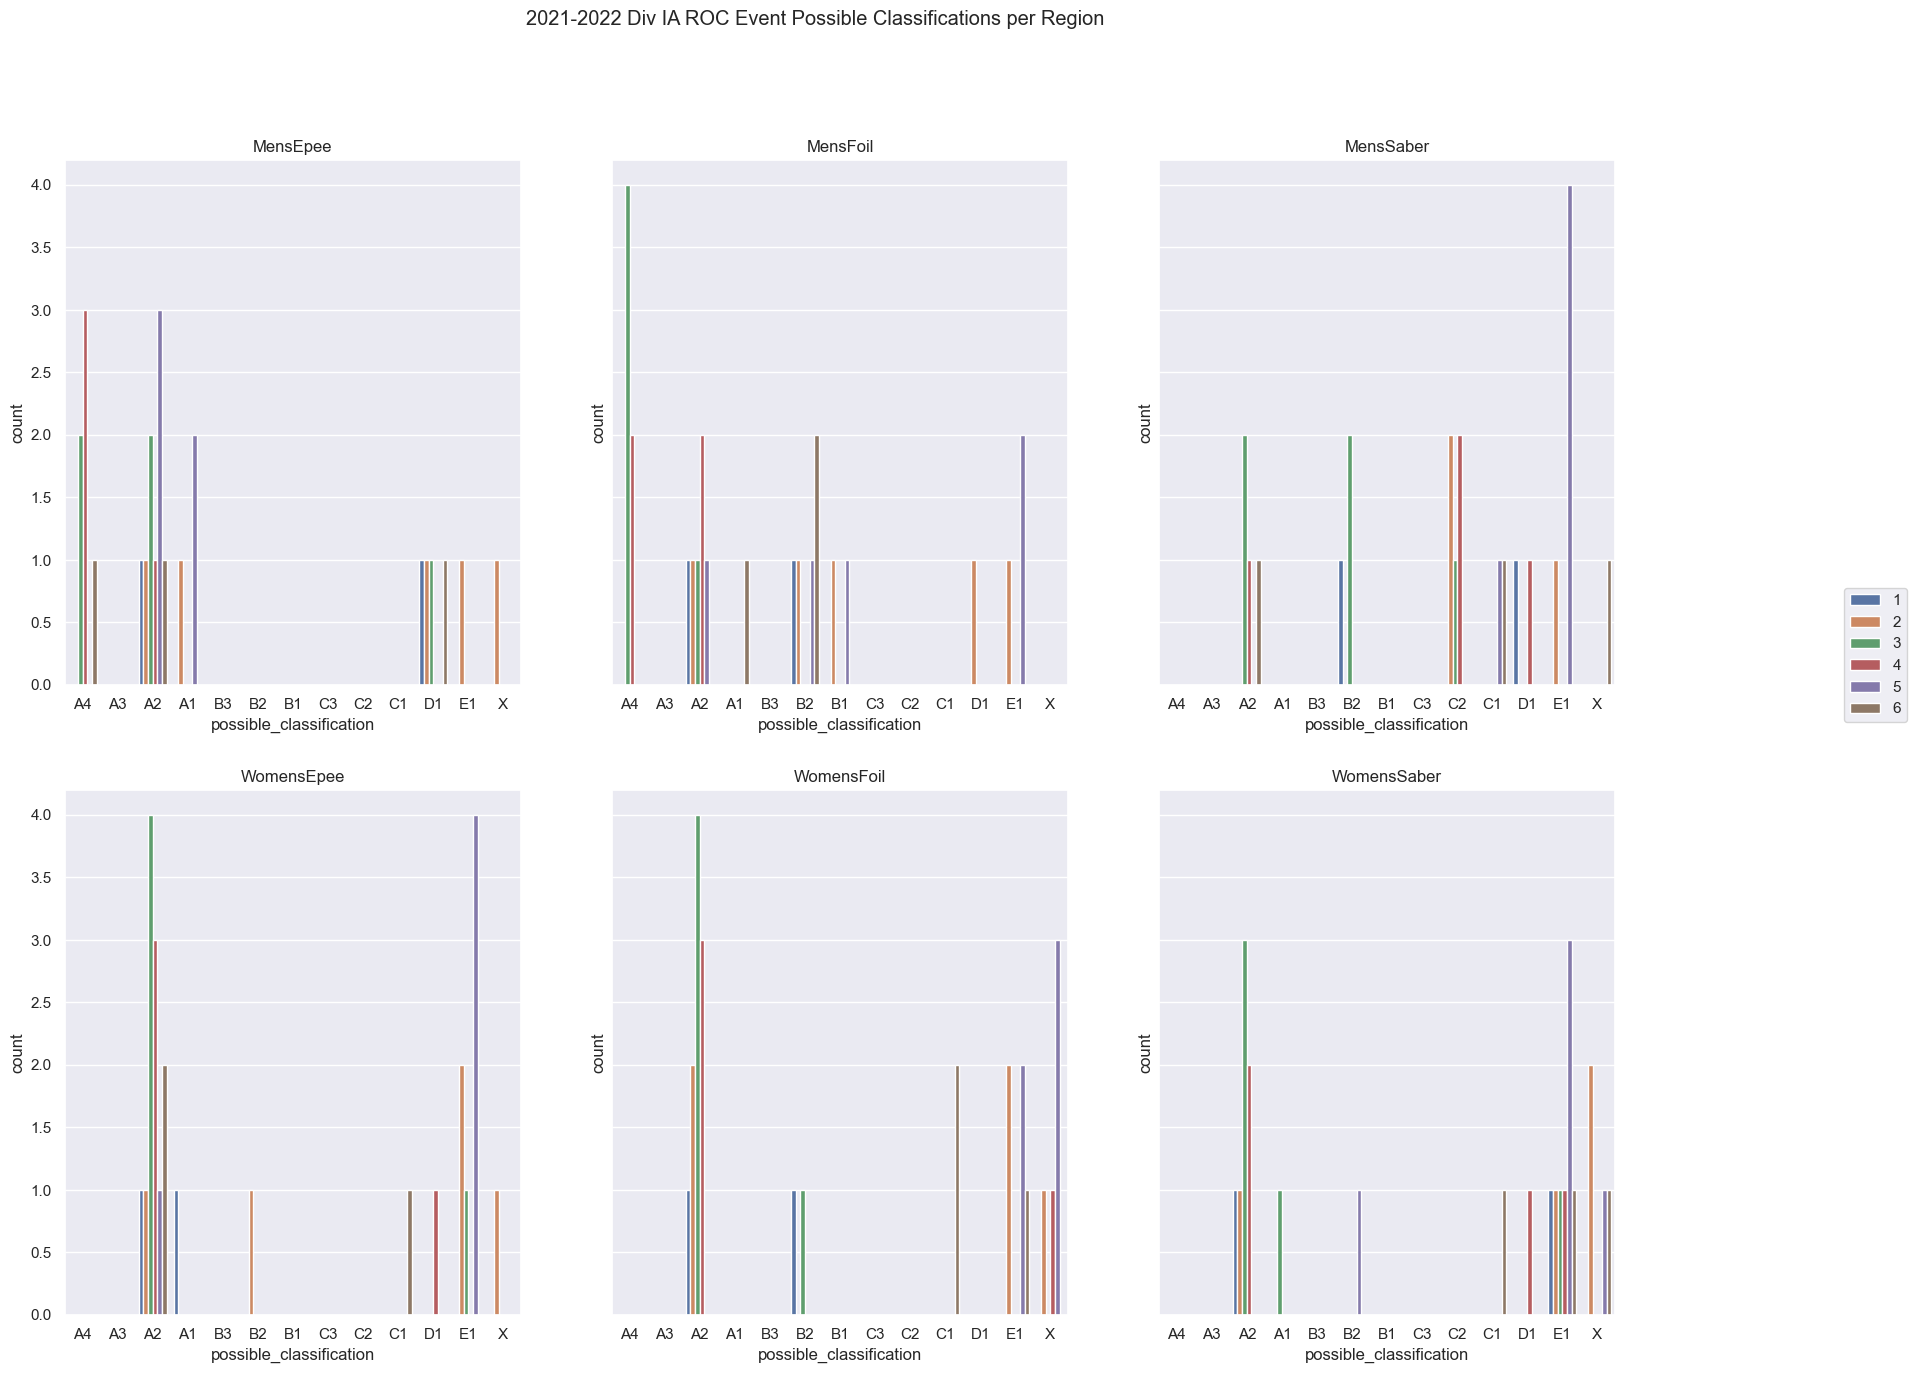

In [9]:
fig, _ = plt.subplots(2,3,figsize=(20,15),sharey=True)
fig.suptitle('2021-2022 Div IA ROC Event Possible Classifications per Region')
df_l = classification_df[classification_df.level=='DivIA']
event_order = ['MensEpee','MensFoil','MensSaber','WomensEpee','WomensFoil','WomensSaber']
for i,ax in enumerate(fig.axes):
    df_l_gw = df_l[df_l.event==event_order[i]]
    a = sns.countplot(ax=ax,data=df_l_gw,x='possible_classification',hue='region',order=ORDER)
    a.get_legend().remove()
    a.set_title(event_order[i])

handles,labels = a.get_legend_handles_labels()
fig.legend(handles,labels,loc='lower right',bbox_to_anchor=(1.05,0.5))

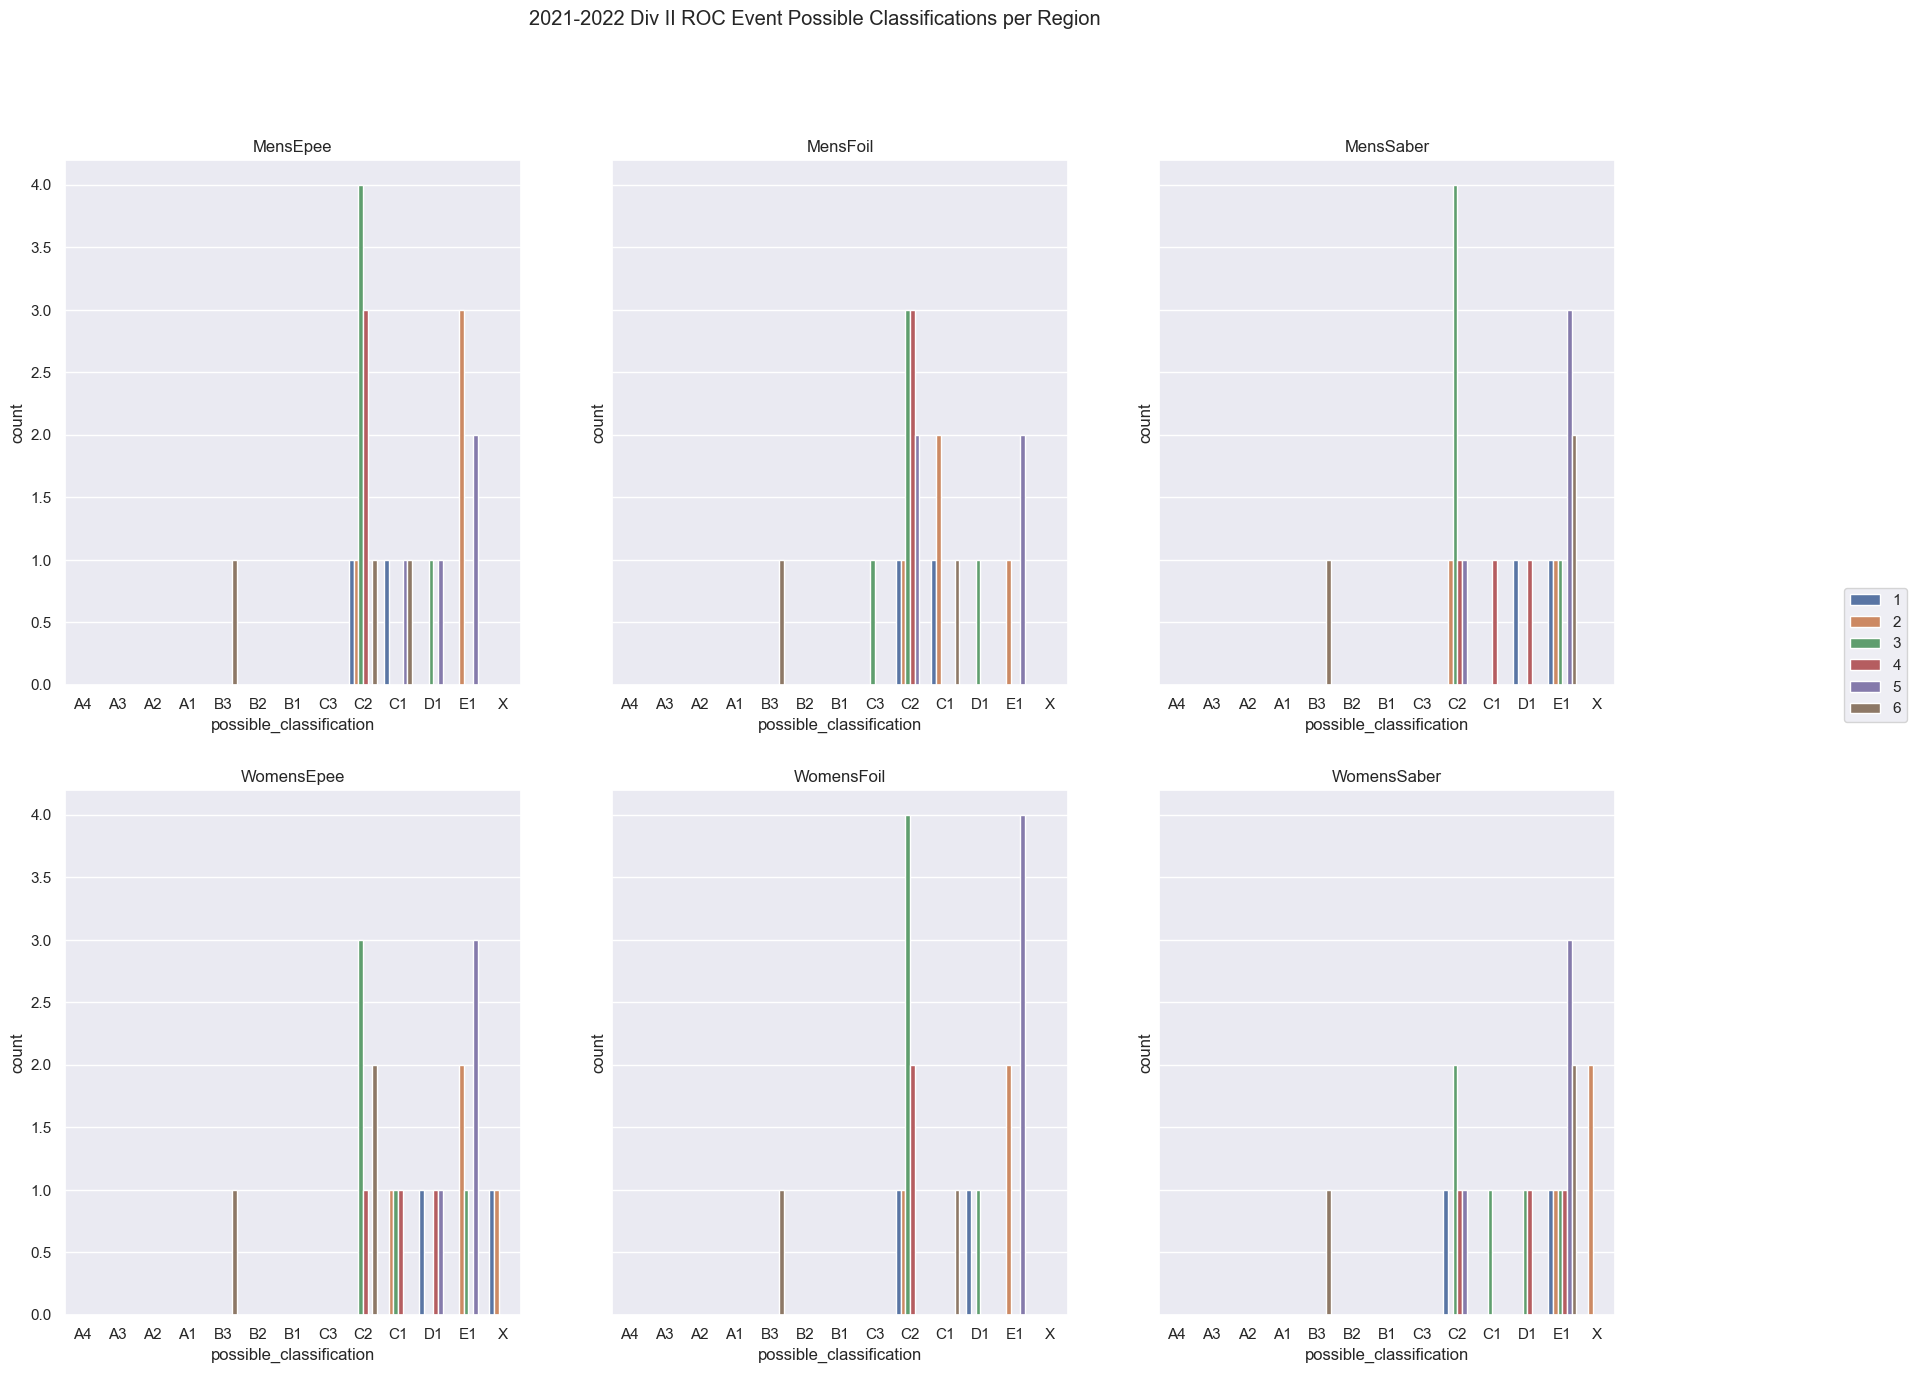

In [10]:
fig, _ = plt.subplots(2,3,figsize=(20,15),sharey=True)
fig.suptitle('2021-2022 Div II ROC Event Possible Classifications per Region')
df_l = classification_df[classification_df.level=='DivII']
event_order = ['MensEpee','MensFoil','MensSaber','WomensEpee','WomensFoil','WomensSaber']
for i,ax in enumerate(fig.axes):
    df_l_gw = df_l[df_l.event==event_order[i]]
    a = sns.countplot(ax=ax,data=df_l_gw,x='possible_classification',hue='region',order=ORDER)
    a.get_legend().remove()
    a.set_title(event_order[i])

handles,labels = a.get_legend_handles_labels()
fig.legend(handles,labels,loc='lower right',bbox_to_anchor=(1.05,0.5))

### Now we can compute the maximum possible number of new ratings earned per region

In [11]:
#for ratings_earned in ['A','B','C','D','E']:
 #   classification_df[ratings_earned] = pd.Series(dtype='int')
MAX_EARNED = {'A4':{'A':8,'B':8,'C':8,'D':8,'E':16},
                'A3':{'A':4,'B':4,'C':8,'D':8,'E':8},
                'A2':{'A':1,'B':3,'C':4,'D':2,'E':2},
                'A1':{'A':1,'B':1,'C':2,'D':2,'E':2},
                'B3':{'A':0,'B':4,'C':4,'D':8,'E':16},
                'B2':{'A':0,'B':1,'C':3,'D':4,'E':4},
                'B1':{'A':0,'B':1,'C':3,'D':2,'E':2},
                'C3':{'A':0,'B':0,'C':4,'D':4,'E':8},
                'C2':{'A':0,'B':0,'C':1,'D':3,'E':4},
                'C1':{'A':0,'B':0,'C':1,'D':3,'E':4},
                'D1':{'A':0,'B':0,'C':0,'D':1,'E':3},
                'E1':{'A':0,'B':0,'C':0,'D':0,'E':1},
                'X':{'A':0,'B':0,'C':0,'D':0,'E':0}}

classification_df['ratings_dict'] = classification_df['possible_classification'].map(MAX_EARNED)
classification_df[['A','B','C','D','E']] = pd.json_normalize(classification_df.ratings_dict)
classification_df.drop(['ratings_dict'],axis=1,inplace=True)
classification_df.head()

,tournament,region,level,event,possible_classification,A,B,C,D,E
0,TFC FallFest DIV2/VET ROC,4,DivII,MensFoil,C2,0,0,1,3,4
1,TFC FallFest DIV2/VET ROC,4,DivII,WomensFoil,C2,0,0,1,3,4
2,TFC FallFest DIV2/VET ROC,4,DivII,MensEpee,C2,0,0,1,3,4
3,TFC FallFest DIV2/VET ROC,4,DivII,WomensEpee,D1,0,0,0,1,3
4,TFC FallFest DIV2/VET ROC,4,DivII,MensSaber,D1,0,0,0,1,3


Text(0.5, 0.98, 'Ratings possible to earn in 2021-2022 DivII Events per region')

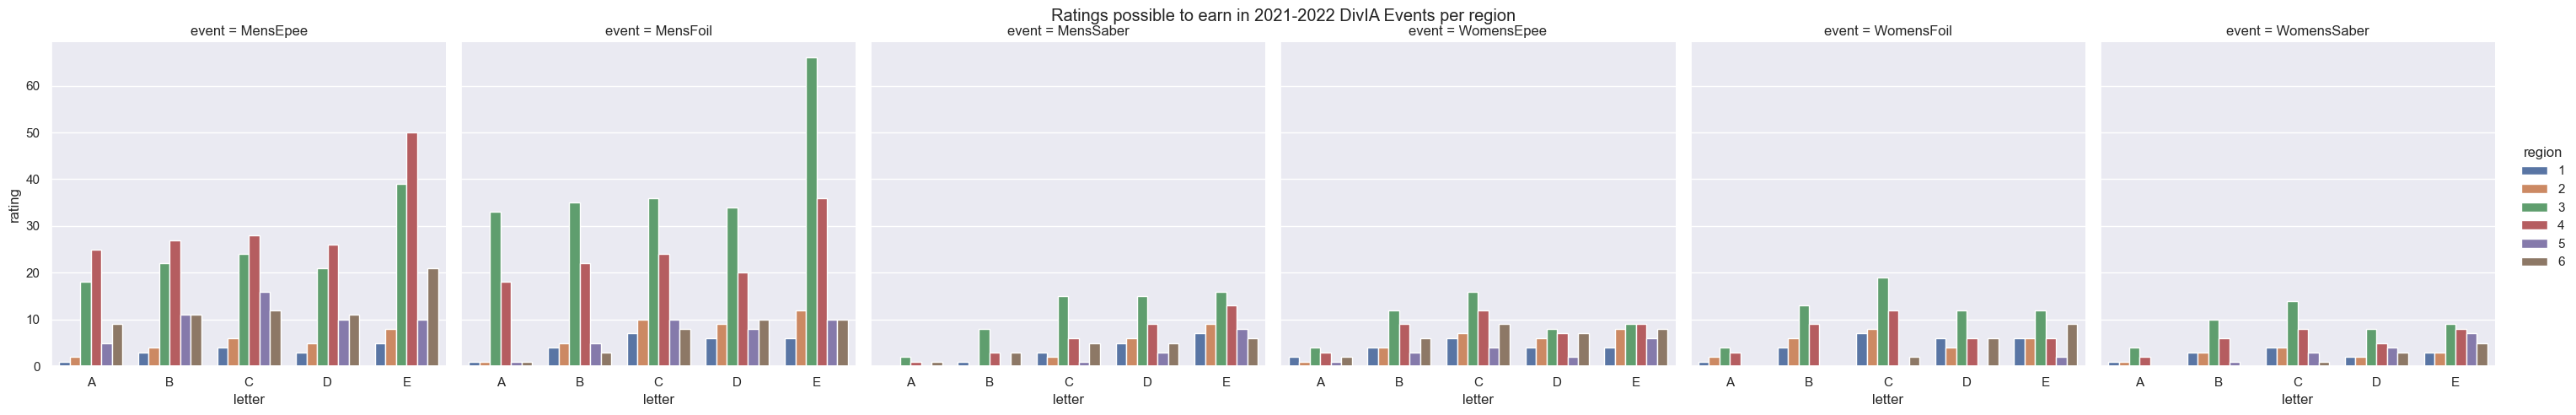

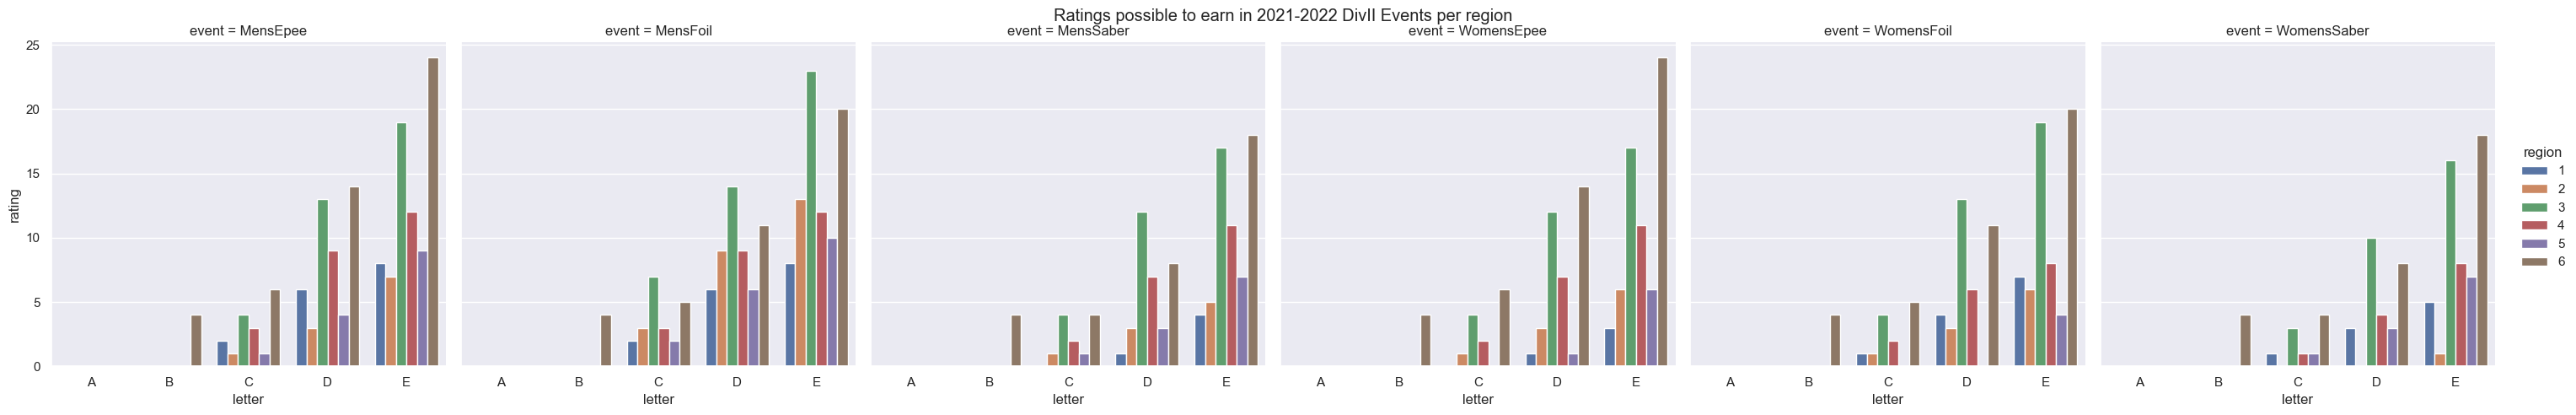

In [26]:
m = classification_df.drop(['tournament','possible_classification'],axis=1)
m = m.groupby(['region','level','event']).sum().reset_index()
melted_divia = m[m.level=='DivIA'].melt(id_vars=['region','event'],value_vars=['A','B','C','D','E'],value_name='rating',var_name='letter')
divia = sns.catplot(x='letter',y='rating',hue='region',col='event',data=melted_divia,kind='bar')
divia.fig.subplots_adjust(top=0.9)
divia.fig.suptitle('Ratings possible to earn in 2021-2022 DivIA Events per region')
melted_divii = m[m.level=='DivII'].melt(id_vars=['region','event'],value_vars=['A','B','C','D','E'],value_name='rating',var_name='letter')
divii = sns.catplot(x='letter',y='rating',hue='region',col='event',data=melted_divii,kind='bar')
divii.fig.subplots_adjust(top=0.9)
divii.fig.suptitle('Ratings possible to earn in 2021-2022 DivII Events per region')

# Now let's see how many ratings were actually earned

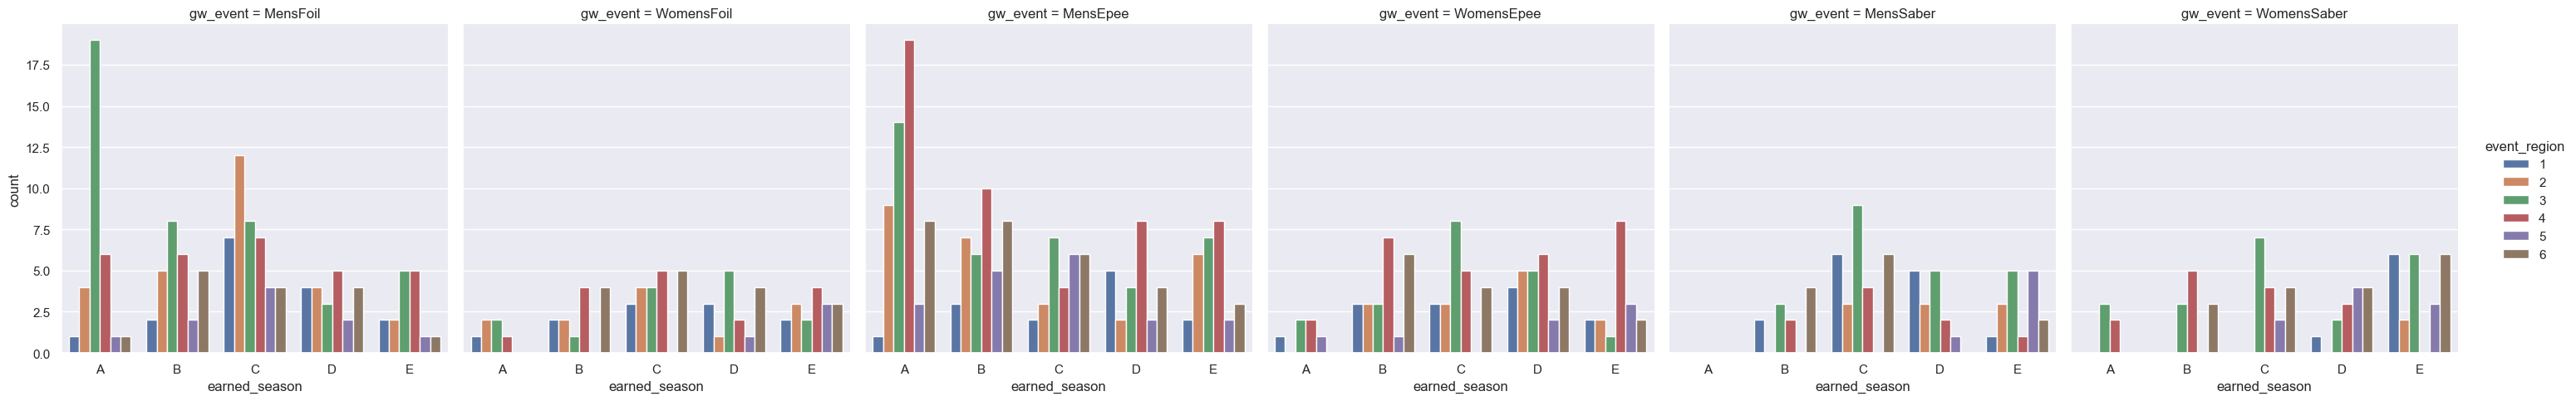

In [33]:
sns.catplot(data=rocs_raw,x="earned_season",hue="event_region",col='gw_event',kind='count',order=sorted(rocs_raw.earned_season.dropna().unique()))

## Mobility to Division 1
Let's find out how many people who were previously ineligible for Division 1 events (i.e. D, E, and U fencers) earned a rating at an ROC event that made them Div 1 eligible (i.e. earned an A, B, or C)

N.B. We remove duplicates after downselecting in case a fencer made the graduation step twice before their new rating was updated

In [ ]:
current = ['D','E','U']
new = ['A','B','C']
mobile = rocs_raw.loc[(rocs_raw.classification_season.isin(current)) & (rocs_raw.earned_season.isin(new))]
mobile.drop_duplicates(subset=['memberNum'],inplace=True)
print(f'Number of fencers who graduated to Div 1 from any ROC: {len(mobile.index)}')

Number of fencers who graduated to Div 1 from any ROC: 108


c:\Users\emace\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 0, 'Event')

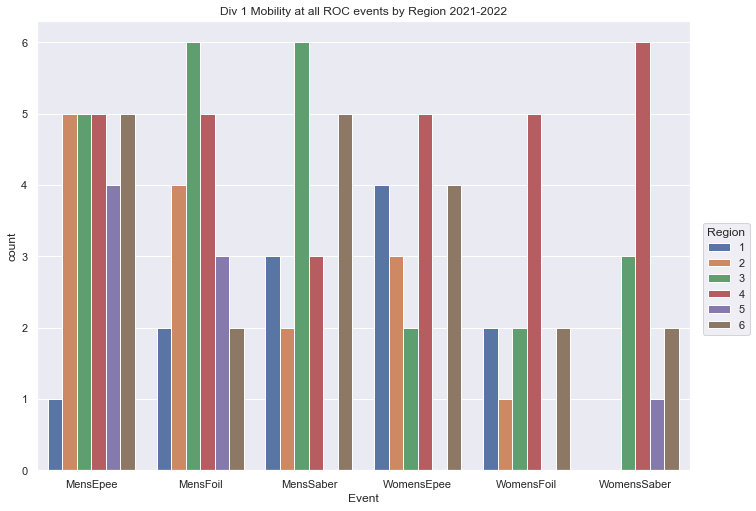

In [ ]:
sns.countplot(data=mobile,x="gw_event",hue="event_region",order=sorted(mobile.gw_event.unique())).set(title='Div 1 Mobility at all ROC events by Region 2021-2022')
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0,title='Region')
plt.xlabel('Event')

## Mobility of Non-Vet Adult Fencers (age 20-40) to Division 1 from ROC events
Now we cross-reference the Div 1 mobile fencers to the membership list to get their birth years

In [ ]:
members = pd.read_csv('members.csv')
members.columns

Index(['Last Name', 'First Name', 'Middle Name', 'Suffix', 'Nickname',
       'Gender', 'Birthdate', 'Birthdate verified', 'Division', 'Section',
       'Club 1 Name', 'Club 1 Abbreviation', 'Club 1 ID#', 'Club 2 Name',
       'Club 2 Abbreviation', 'Club 2 ID#', 'School Name',
       'School Abbreviation', 'School ID#', 'Member #', 'Member Type',
       'CheckEd', 'Competitive', 'Expiration', 'Saber', 'Epee', 'Foil',
       'US Citizen', 'Permanent Resident', 'Representing Country', 'Region #',
       'Background Check Expires', 'SafeSport Expires', 'Non-Comp Eligible',
       'Referee Highest USA Rating Earned', 'Referee USA Rating Foil',
       'Referee USA Year Foil', 'Referee USA Rating Epee',
       'Referee USA Year Epee', 'Referee USA Rating Saber',
       'Referee USA Year Saber', 'Referee FIE Rating Foil',
       'Referee FIE Year Foil', 'Referee FIE Rating Epee',
       'Referee FIE Year Epee', 'Referee FIE Rating Saber',
       'Referee FIE Year Saber', 'Updated At', 'Last 

In [ ]:
mobile_with_ages = pd.merge(mobile,members[['Birthdate','Member #']],left_on='memberNum',right_on='Member #')
mobile_adults = mobile_with_ages[mobile_with_ages['Birthdate'].between(1983,2003)]
print(f'Number of adult (20-40) fencers who graduated to Div 1 from any ROC: {len(mobile_adults.index)}')

Number of adult (20-40) fencers who graduated to Div 1 from any ROC: 26


Text(0.5, 0, 'Event')

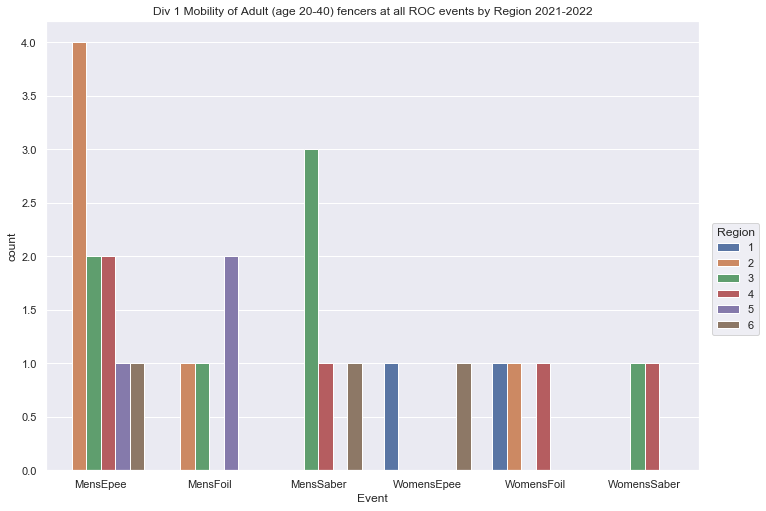

In [ ]:
sns.countplot(data=mobile_adults,x="gw_event",hue="event_region",order=sorted(mobile.gw_event.unique())).set(title='Div 1 Mobility of Adult (age 20-40) fencers at all ROC events by Region 2021-2022')
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0,title='Region')
plt.xlabel('Event')